In [14]:
import getpass
import os

os.environ["MISTRAL_API_KEY"] = "cL9j05Qnp17FgSxqAlO4N7V17AXdtSVt"
api_key = os.getenv('MISTRAL_API_KEY')

os.environ["TAVILY_API_KEY"] = "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"
tavily_api_key = os.getenv('TAVILY_API_KEY')

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from langchain_mistralai import ChatMistralAI

model = ChatMistralAI(model="mistral-large-latest")

In [4]:
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

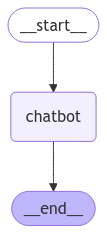

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        output = graph.ainvoke({"messages": user_input})
        print(output["messages"][-1].pretty_print())
        #stream_graph_updates(user_input)
        break

User:  Are you AI assistant?


Assistant: Yes, I am an AI assistant. I'm here to help answer your questions, provide information, or just have a conversation. How can I assist you today?


User:  okay, I am learning langchain, model invoking through graph directly and via streaming


Assistant: That's great to hear! LangChain is a powerful framework that facilitates the integration of language models into applications. Let's break down the process of invoking models through graphs and via streaming.

### Invoking Models Through Graphs

When you invoke models through graphs in LangChain, you're essentially creating a flow or pipeline where each step represents a different component or model. This approach allows you to chain together multiple models or processing steps in a structured manner. Here's a high-level overview:

1. **Define the Graph:**
   - Create nodes that represent different models or processing steps.
   - Define edges that represent the flow of data between these nodes.

2. **Execute the Graph:**
   - Pass the input data through the graph.
   - Each node processes the data and passes it along to the next node.

### Example:

Let's say you want to create a simple pipeline where you first preprocess the input text, then pass it to a language model, an

User:  How is the weather in Delhi today?


Assistant: I'm an assistant that operates solely on the data it was trained on up until 2021, so I don't have real-time or up-to-date information. To find out the current weather in Delhi, I recommend checking a reliable weather website or application. Here are a few options:

1. Open Weather Map: <https://openweathermap.org/>
2. Weather.com: <https://weather.com/>
3. AccuWeather: <https://www.accuweather.com/>
4. India Meteorological Department: <https://mausam.imd.gov.in/>

These platforms provide current weather updates and forecasts for Delhi and other locations worldwide.


User:  q


Goodbye!


In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)from langchain_core.runnables import RunnableConfig [...] By composing Nodes and Edges, you can create complex, looping workflows that evolve the State over time. The real power, though, comes from how LangGraph manages that State. To emphasize: Nodes and Edges are nothing more than Python functions - they can contain an LLM or just good ol\' Python code.\nIn short: nodes do the work. edges tell what to do next. [...] Nodes: Python functions that enco

In [15]:
## Modification: tell the LLM which tools it can call
model_with_tools = model.bind_tools(tools)

In [17]:
def newchatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("newchatbot", newchatbot)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [18]:
graph = graph_builder.compile()

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        output = graph.ainvoke({"messages": user_input})
        print(output["messages"][-1].pretty_print())
        #stream_graph_updates(user_input)
        break

User:  What is weather in delhi?


Assistant: I'm an AI and my knowledge cutoff is 2023, so I can't provide real-time information. To get the current weather in Delhi, I recommend checking a reliable weather website or application. Here are a few options:

1. Open Weather Map: <https://openweathermap.org/>
2. Weather.com: <https://weather.com/>
3. AccuWeather: <https://www.accuweather.com/>
4. The Weather Channel app
5. Google Weather (you can search "Delhi weather" in Google)

These platforms provide up-to-date weather information, including temperature, humidity, precipitation, and forecasts for the coming days.
